# TaniFi DiLoCo Analysis Notebook

This notebook analyzes the results from DiLoCo federated learning simulations for the research paper.

**Paper Title:** Simulation of Bandwidth-Efficient Federated Learning Architectures for Resource-Constrained Agricultural Networks in Indonesia

## Sections:
1. Load and Explore Results
2. Training Metrics Analysis
3. Bandwidth Efficiency Analysis
4. Per-Farmer Contribution Analysis
5. Comparison with Centralized Training
6. Generate Paper-Ready Figures

In [10]:
# Import libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style for paper-quality plots
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

# Configure matplotlib for better quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## 1. Load Results

In [11]:
# Load all experiment results (18 configurations)
results_dir = Path('../experiments/results')
result_files = sorted(results_dir.glob('diloco_*.json'))

if not result_files:
    print("❌ No results found. Run simulation first!")
else:
    print(f"📂 Found {len(result_files)} experiment files\n")
    
    all_experiments = []
    
    for result_file in result_files:
        with open(result_file, 'r') as f:
            data = json.load(f)
        
        config = data['configuration']
        metrics = data['results']['metrics']
        summary = data['results']['summary']
        
        exp_record = {
            'num_farmers': config['num_farmers'],
            'local_steps': config['local_steps'],
            'num_rounds': len(metrics['rounds']),
            'initial_loss': summary['initial_loss'],
            'final_loss': summary['final_loss'],
            'loss_reduction_pct': summary['loss_reduction_percent'],
            'avg_bandwidth_saved': summary['avg_bandwidth_saved_percent'],
            'rounds_data': metrics['rounds'],
            'loss_data': metrics['avg_loss'],
            'bandwidth_data': metrics['bandwidth_saved']
        }
        all_experiments.append(exp_record)
    
    # Create DataFrame
    df_experiments = pd.DataFrame(all_experiments)
    df_experiments = df_experiments.sort_values(['num_farmers', 'local_steps']).reset_index(drop=True)
    
    print("📊 Experiments Summary:")
    display(df_experiments[['num_farmers', 'local_steps', 'num_rounds', 'initial_loss', 
                            'final_loss', 'loss_reduction_pct', 'avg_bandwidth_saved']])
    
    print(f"\n📈 Configuration Summary:")
    print(f"  - Total configurations: {len(df_experiments)}")
    print(f"  - Farmers: {sorted(df_experiments['num_farmers'].unique())}")
    print(f"  - Steps: {sorted(df_experiments['local_steps'].unique())}")
    print(f"  - Rounds: {df_experiments['num_rounds'].iloc[0]}")

📂 Found 1 experiment files

📊 Experiments Summary:


,num_farmers,local_steps,num_rounds,initial_loss,final_loss,loss_reduction_pct,avg_bandwidth_saved
0,100,300,10,2.306213,2.303341,0.124552,98.868375



📈 Configuration Summary:
  - Total configurations: 1
  - Farmers: [100]
  - Steps: [300]
  - Rounds: 10


## 2. Training Convergence Analysis

/tmp/ipykernel_2590/3329304943.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=9)


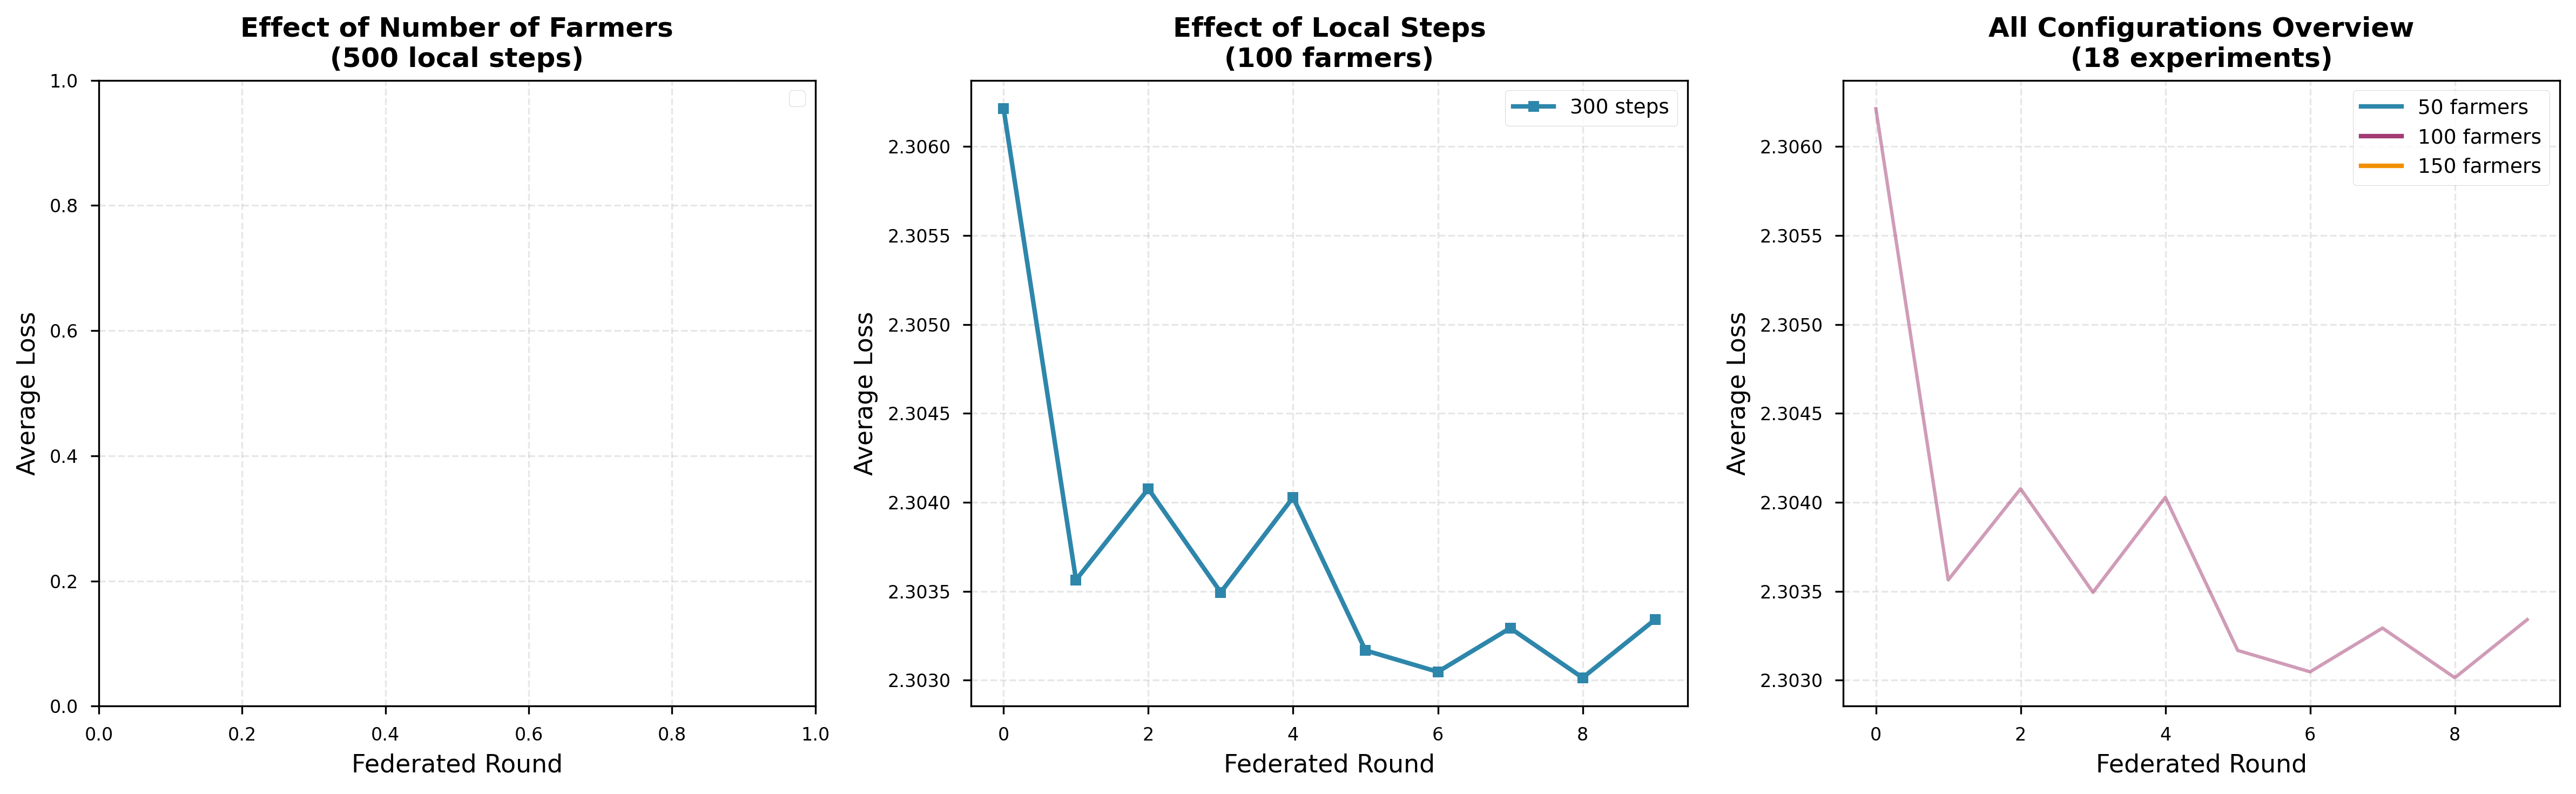

📊 Plotted 1 configurations with 10 rounds each


In [12]:
# Plot training convergence comparison across different configurations
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Color palettes
farmer_colors = {50: '#2E86AB', 100: '#A23B72', 150: '#F18F01'}
step_colors = {50: '#C73E1D', 100: '#F18F01', 300: '#2E86AB', 500: '#06A77D', 700: '#A23B72', 1000: '#3D348B'}

# Plot 1: Effect of number of farmers (fix steps=500)
ax1 = axes[0]
for farmers in sorted(df_experiments['num_farmers'].unique()):
    subset = df_experiments[(df_experiments['num_farmers'] == farmers) & 
                            (df_experiments['local_steps'] == 500)]
    if len(subset) > 0:
        row = subset.iloc[0]
        ax1.plot(row['rounds_data'], row['loss_data'], 
                marker='o', linewidth=2, markersize=5,
                label=f'{farmers} farmers', color=farmer_colors.get(farmers, '#333'))

ax1.set_xlabel('Federated Round', fontsize=11)
ax1.set_ylabel('Average Loss', fontsize=11)
ax1.set_title('Effect of Number of Farmers\n(500 local steps)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=9)

# Plot 2: Effect of local steps (fix farmers=100)
ax2 = axes[1]
for steps in sorted(df_experiments['local_steps'].unique()):
    subset = df_experiments[(df_experiments['num_farmers'] == 100) & 
                            (df_experiments['local_steps'] == steps)]
    if len(subset) > 0:
        row = subset.iloc[0]
        ax2.plot(row['rounds_data'], row['loss_data'], 
                marker='s', linewidth=2, markersize=5,
                label=f'{steps} steps', color=step_colors.get(steps, '#333'))

ax2.set_xlabel('Federated Round', fontsize=11)
ax2.set_ylabel('Average Loss', fontsize=11)
ax2.set_title('Effect of Local Steps\n(100 farmers)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=9)

# Plot 3: All configurations overview
ax3 = axes[2]
for _, row in df_experiments.iterrows():
    ax3.plot(row['rounds_data'], row['loss_data'], 
            linewidth=1.5, alpha=0.5,
            color=farmer_colors.get(row['num_farmers'], '#333'))

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=farmer_colors[f], linewidth=2, label=f'{f} farmers') 
                   for f in sorted(farmer_colors.keys())]
ax3.legend(handles=legend_elements, fontsize=9)

ax3.set_xlabel('Federated Round', fontsize=11)
ax3.set_ylabel('Average Loss', fontsize=11)
ax3.set_title('All Configurations Overview\n(18 experiments)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(results_dir / 'plots' / 'convergence_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Plotted {len(df_experiments)} configurations with {df_experiments['num_rounds'].max()} rounds each")

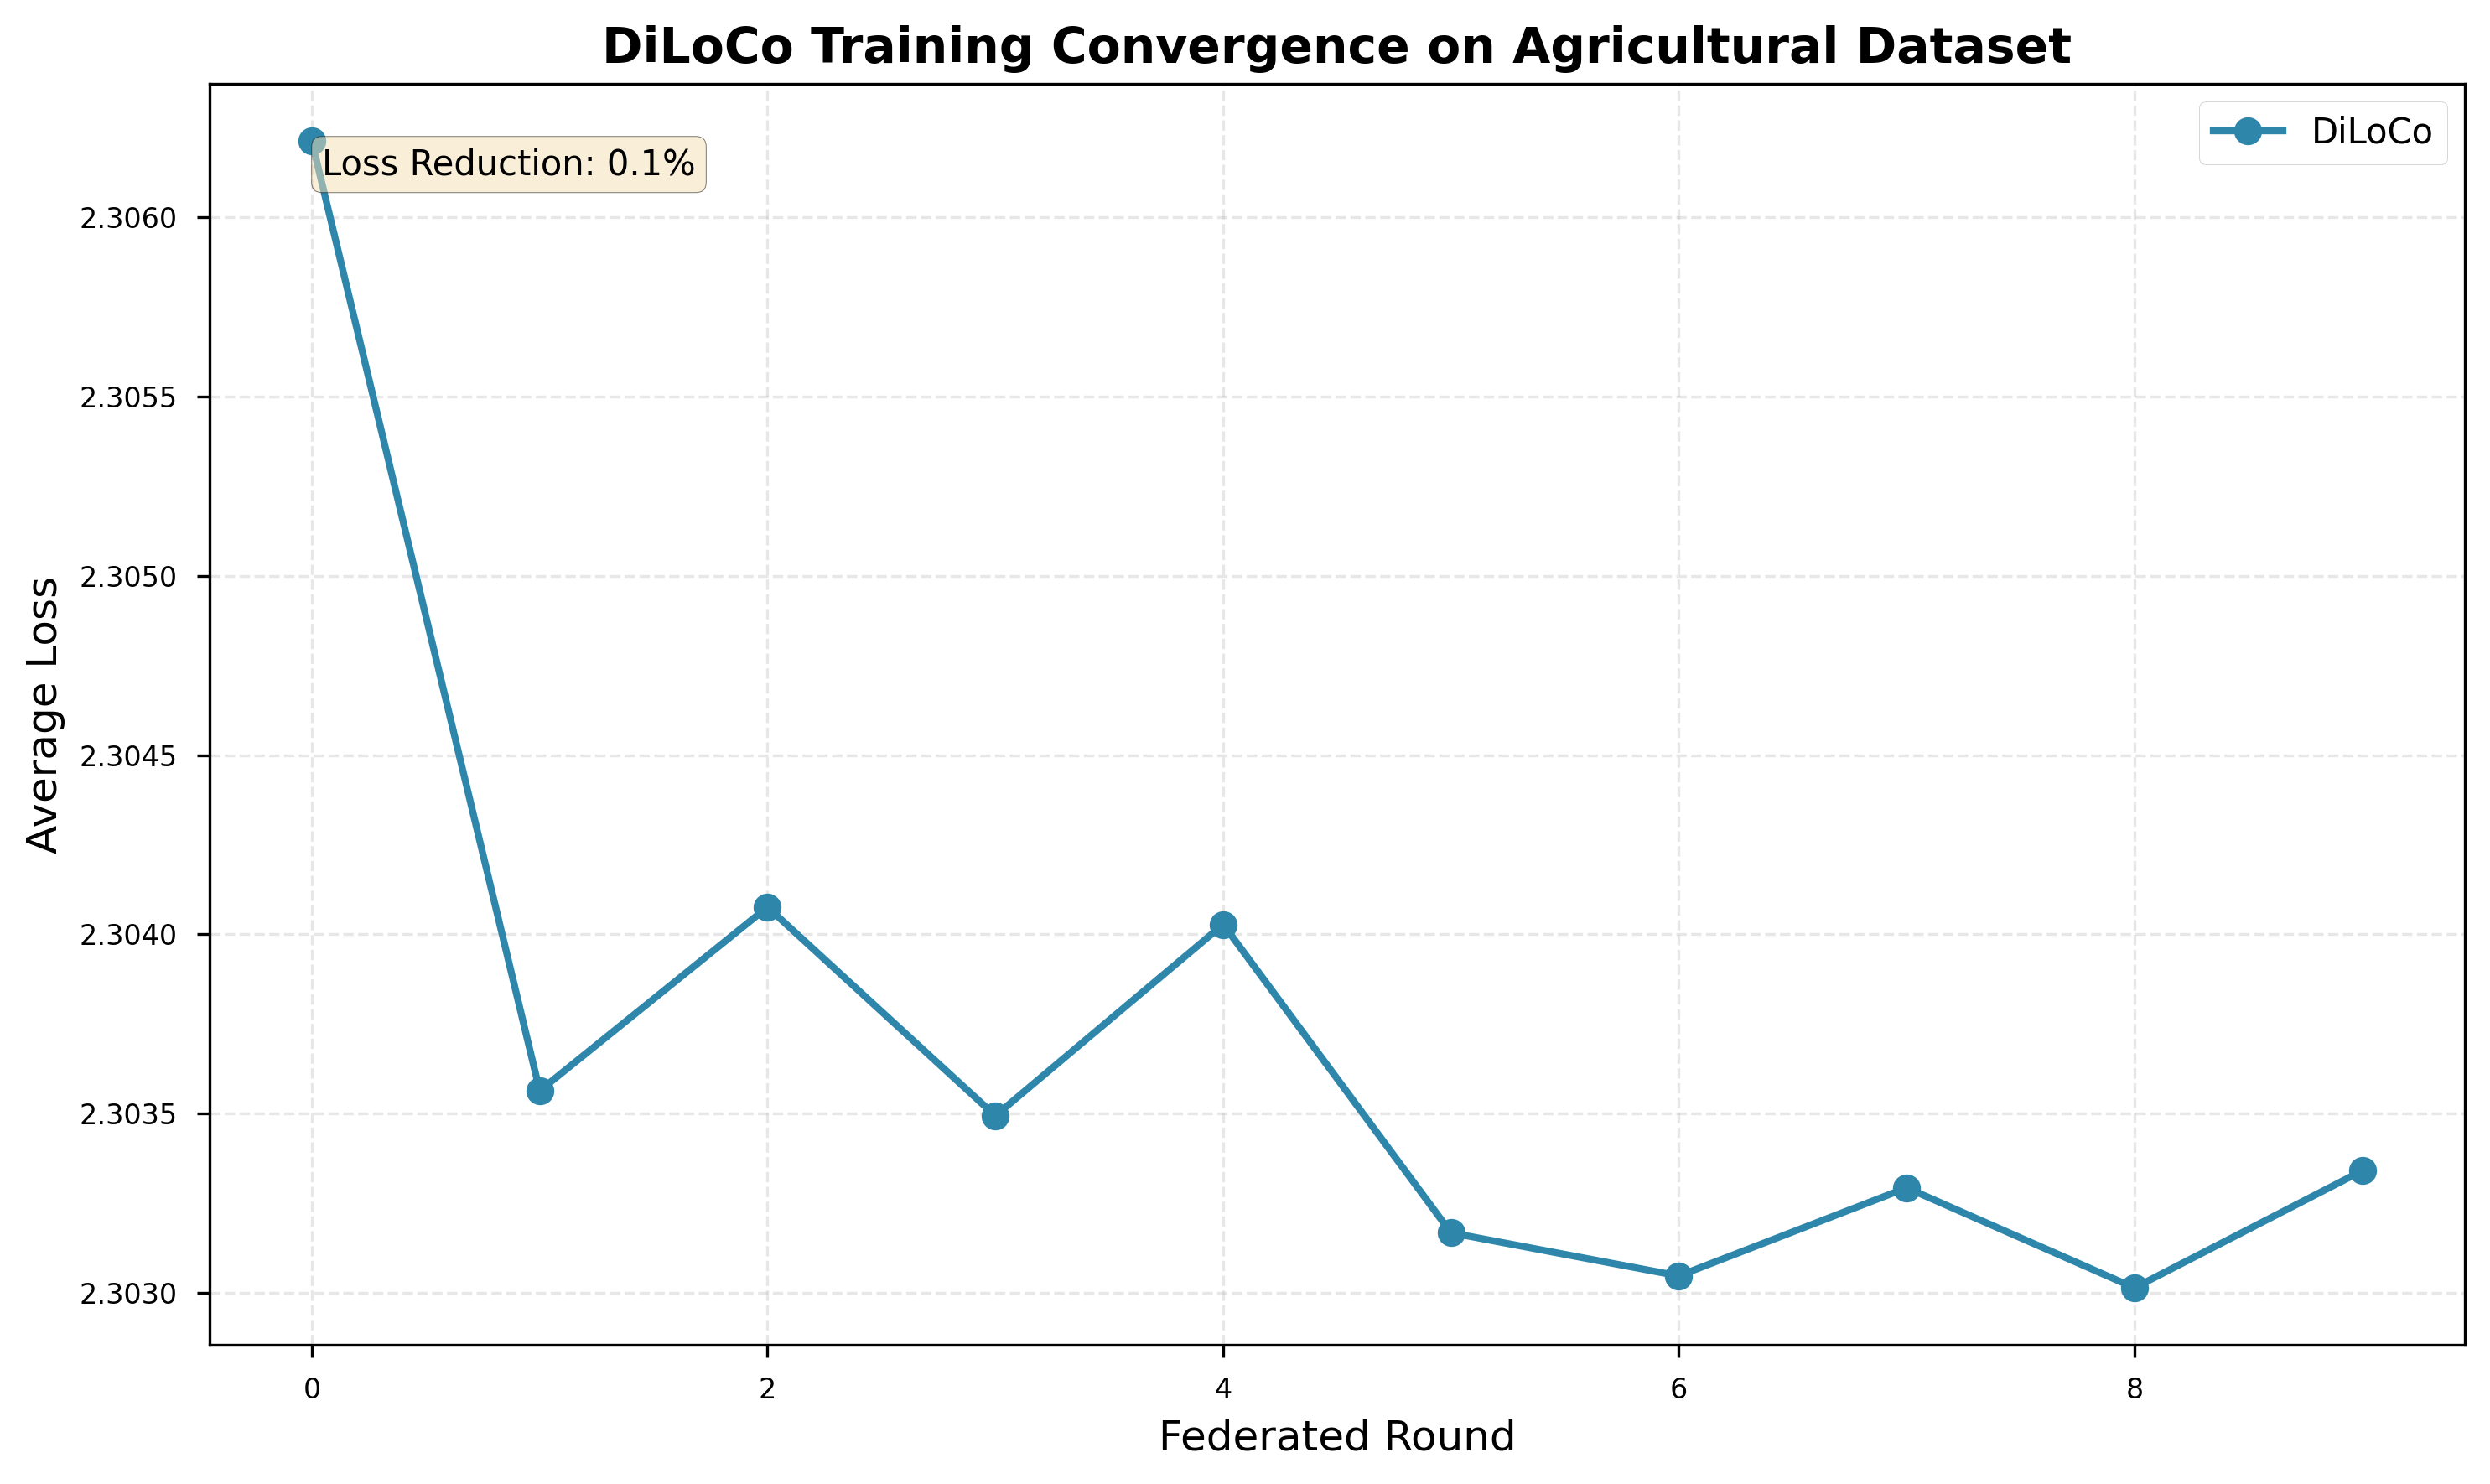

📉 Initial Loss: 2.3062
📉 Final Loss: 2.3033
📈 Improvement: 0.12%
⚙️ Config: 100 farmers, 300 steps


In [13]:
# Plot single convergence analysis (best configuration)
fig, ax = plt.subplots(figsize=(10, 6))

# Get best configuration
best_config = df_experiments.loc[df_experiments['loss_reduction_pct'].idxmax()]

ax.plot(best_config['rounds_data'], best_config['loss_data'], 
        marker='o', linewidth=2, markersize=8, label='DiLoCo', color='#2E86AB')

ax.set_xlabel('Federated Round', fontsize=12)
ax.set_ylabel('Average Loss', fontsize=12)
ax.set_title('DiLoCo Training Convergence on Agricultural Dataset', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=10)

# Add annotations
initial_loss = best_config['loss_data'][0]
final_loss = best_config['loss_data'][-1]
improvement = (initial_loss - final_loss) / initial_loss * 100

ax.text(0.05, 0.95, f'Loss Reduction: {improvement:.1f}%', 
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(results_dir / 'plots' / 'convergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📉 Initial Loss: {initial_loss:.4f}")
print(f"📉 Final Loss: {final_loss:.4f}")
print(f"📈 Improvement: {improvement:.2f}%")
print(f"⚙️ Config: {int(best_config['num_farmers'])} farmers, {int(best_config['local_steps'])} steps")

## 3. Bandwidth Efficiency Analysis

Key metric for the paper: DiLoCo's communication efficiency compared to traditional federated learning

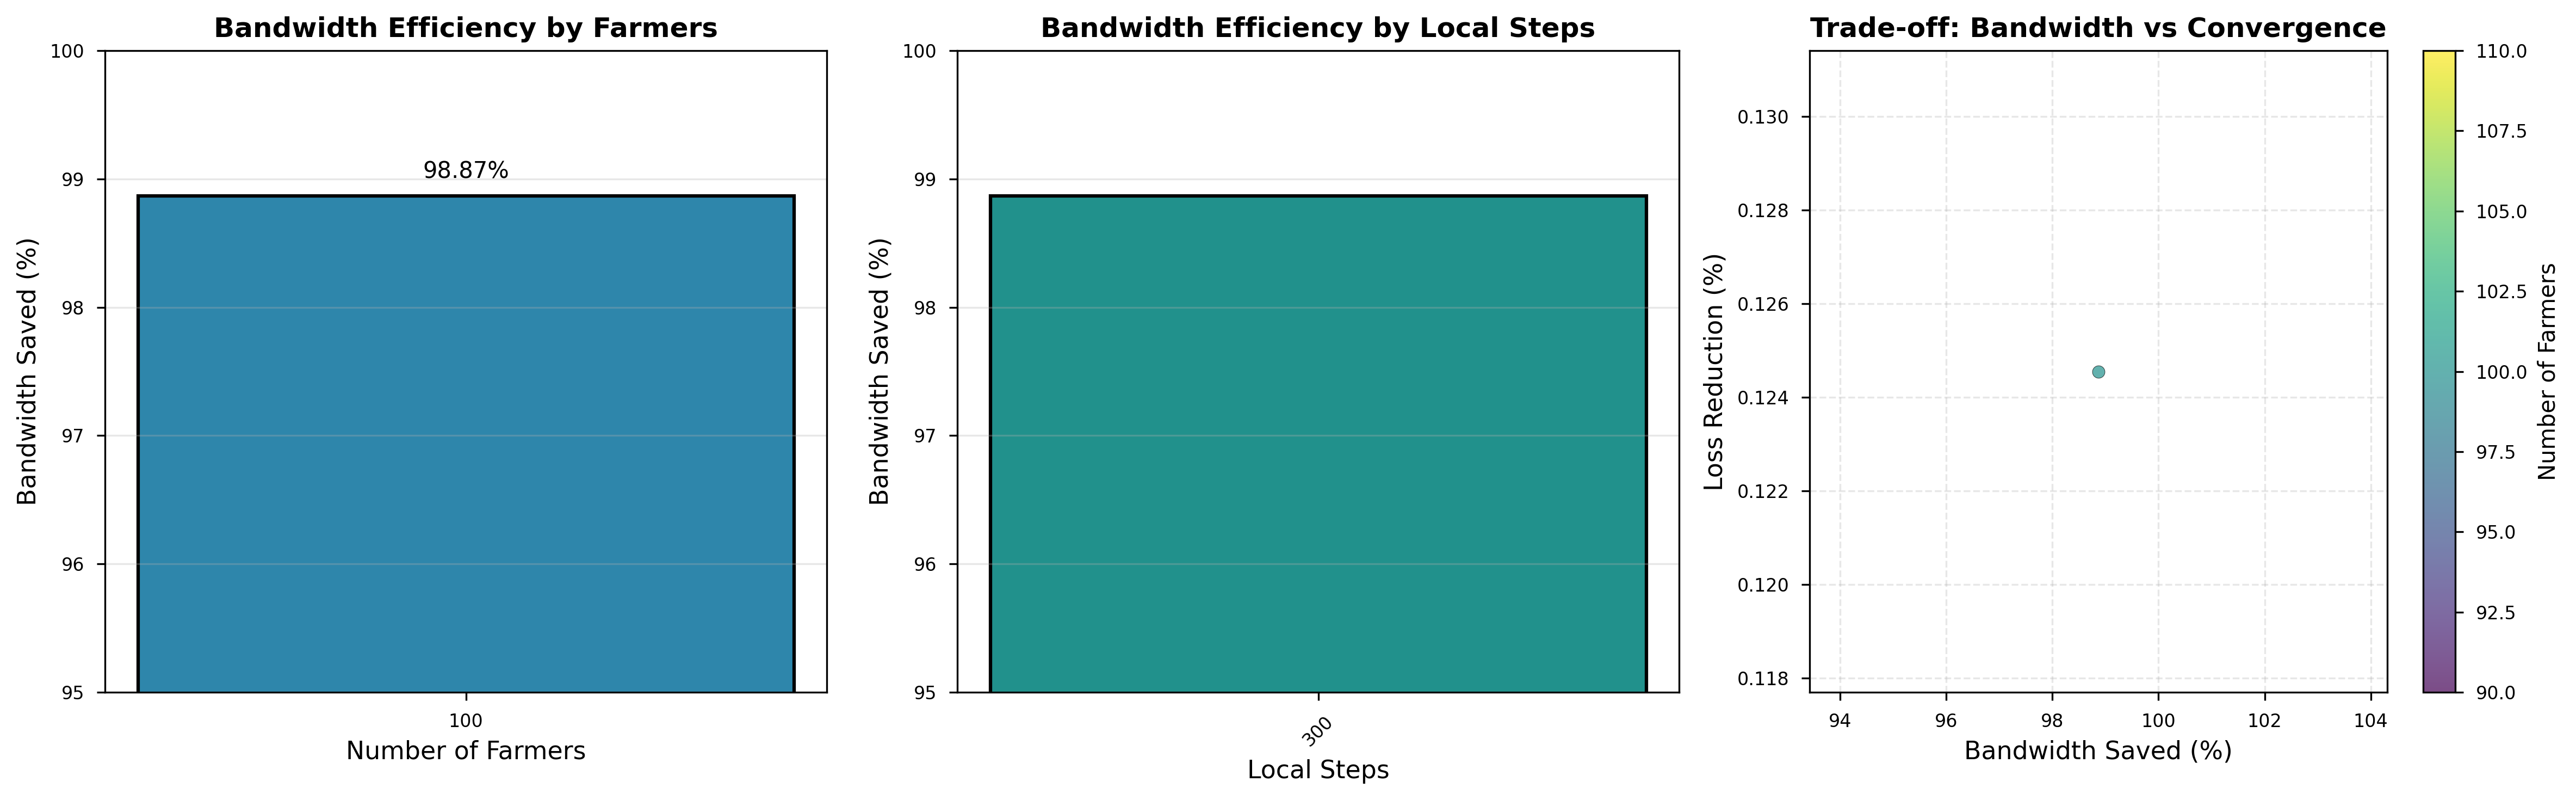


💾 Overall Average Bandwidth Savings: 98.87%
💾 Range: 98.87% - 98.87%


In [5]:
# Bandwidth savings analysis across configurations
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Bandwidth saved vs Number of Farmers
ax1 = axes[0]
bandwidth_by_farmers = df_experiments.groupby('num_farmers')['avg_bandwidth_saved'].mean()
bars1 = ax1.bar(bandwidth_by_farmers.index.astype(str), bandwidth_by_farmers.values, 
               color=['#2E86AB', '#A23B72', '#F18F01'], edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Number of Farmers', fontsize=11)
ax1.set_ylabel('Bandwidth Saved (%)', fontsize=11)
ax1.set_title('Bandwidth Efficiency by Farmers', fontsize=12, fontweight='bold')
ax1.set_ylim([95, 100])
ax1.grid(True, alpha=0.3, axis='y')
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
            f'{bar.get_height():.2f}%', ha='center', va='bottom', fontsize=10)

# Plot 2: Bandwidth saved vs Local Steps
ax2 = axes[1]
bandwidth_by_steps = df_experiments.groupby('local_steps')['avg_bandwidth_saved'].mean()
bars2 = ax2.bar(bandwidth_by_steps.index.astype(str), bandwidth_by_steps.values,
               color=sns.color_palette("viridis", len(bandwidth_by_steps)), edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Local Steps', fontsize=11)
ax2.set_ylabel('Bandwidth Saved (%)', fontsize=11)
ax2.set_title('Bandwidth Efficiency by Local Steps', fontsize=12, fontweight='bold')
ax2.set_ylim([95, 100])
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Loss reduction vs Bandwidth saved (scatter)
ax3 = axes[2]
scatter = ax3.scatter(df_experiments['avg_bandwidth_saved'], 
                      df_experiments['loss_reduction_pct'],
                      c=df_experiments['num_farmers'], 
                      s=df_experiments['local_steps'] / 10,
                      cmap='viridis', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Bandwidth Saved (%)', fontsize=11)
ax3.set_ylabel('Loss Reduction (%)', fontsize=11)
ax3.set_title('Trade-off: Bandwidth vs Convergence', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--')
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Number of Farmers', fontsize=10)

plt.tight_layout()
plt.savefig(results_dir / 'plots' / 'bandwidth_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Overall Average Bandwidth Savings: {df_experiments['avg_bandwidth_saved'].mean():.2f}%")
print(f"💾 Range: {df_experiments['avg_bandwidth_saved'].min():.2f}% - {df_experiments['avg_bandwidth_saved'].max():.2f}%")

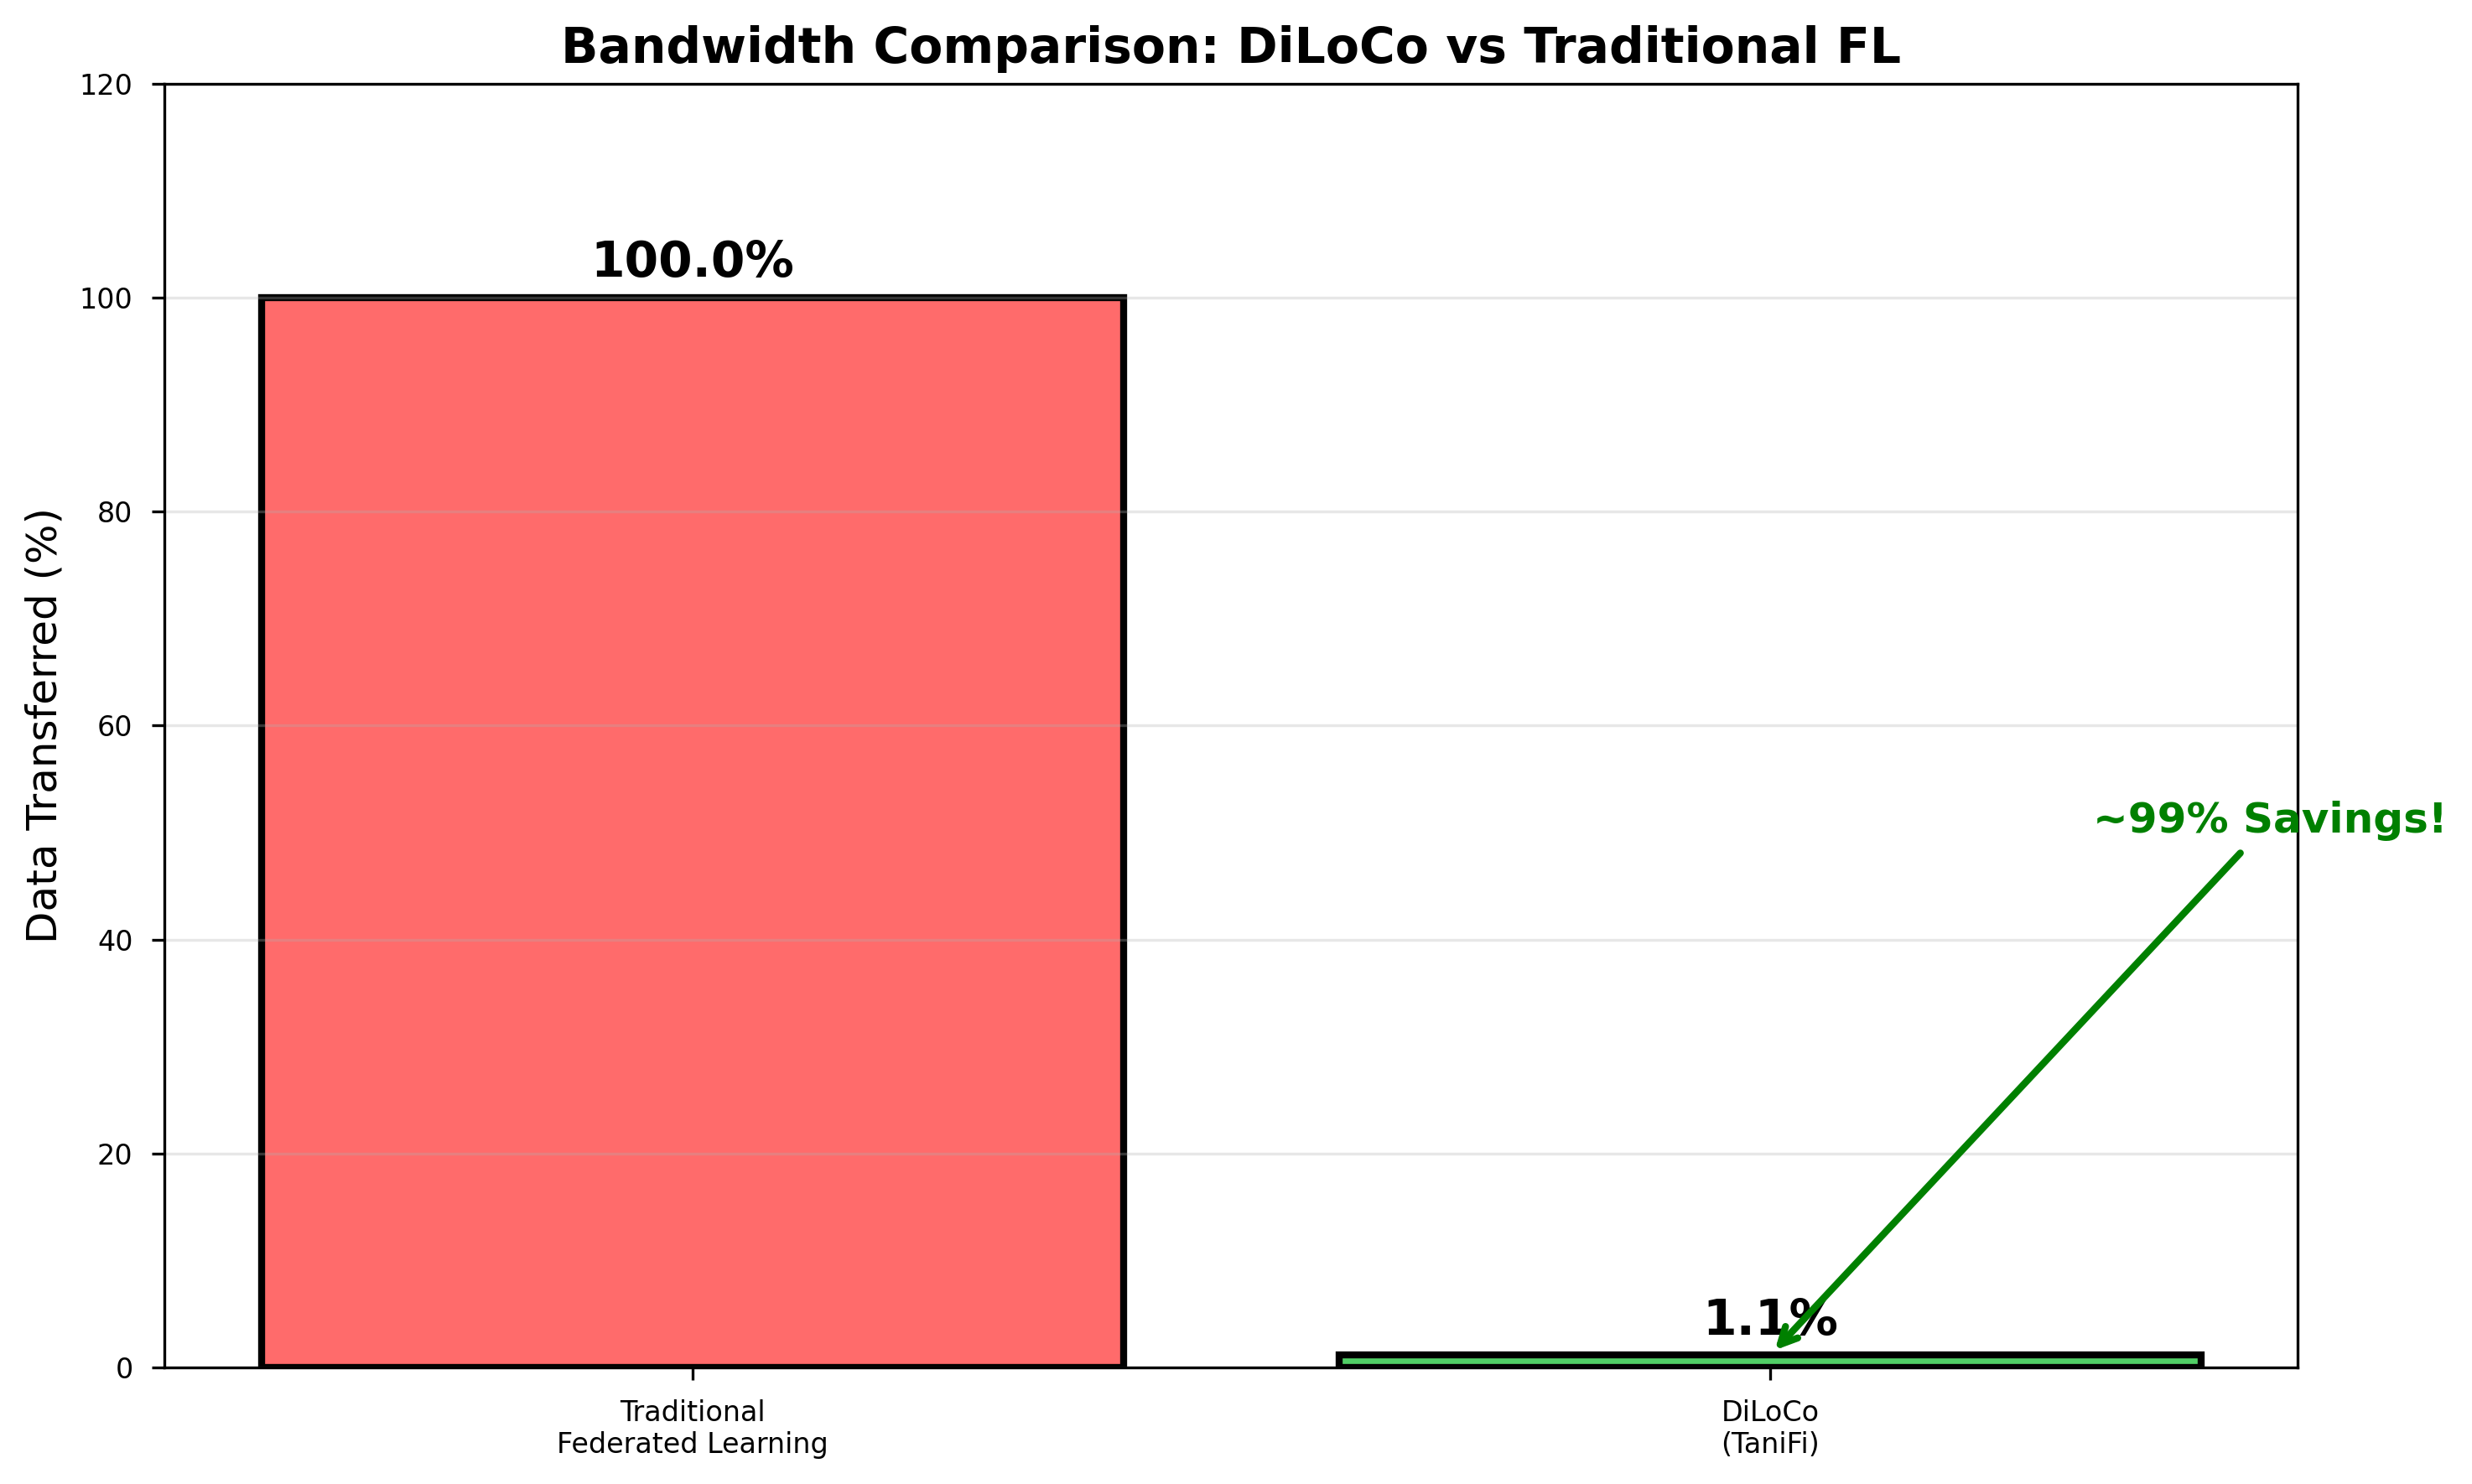

💾 DiLoCo reduces data transfer by 98.9%
💾 Farmers only need to send 1.13% of data compared to traditional FL


In [6]:
# Simple bandwidth efficiency comparison (DiLoCo vs Traditional FL)
fig, ax = plt.subplots(figsize=(10, 6))

avg_bandwidth_saved = df_experiments['avg_bandwidth_saved'].mean()

methods = ['Traditional\nFederated Learning', 'DiLoCo\n(TaniFi)']
data_transferred = [100, 100 - avg_bandwidth_saved]

colors = ['#ff6b6b', '#51cf66']
bars = ax.bar(methods, data_transferred, color=colors, edgecolor='black', linewidth=2)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Data Transferred (%)', fontsize=12)
ax.set_title('Bandwidth Comparison: DiLoCo vs Traditional FL', fontsize=14, fontweight='bold')
ax.set_ylim([0, 120])
ax.grid(True, alpha=0.3, axis='y')

# Add annotation
ax.annotate(f'~{avg_bandwidth_saved:.0f}% Savings!', 
            xy=(1, data_transferred[1]), 
            xytext=(1.3, 50),
            fontsize=12, fontweight='bold', color='green',
            arrowprops=dict(arrowstyle='->', color='green', lw=2))

plt.tight_layout()
plt.savefig(results_dir / 'plots' / 'bandwidth_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 DiLoCo reduces data transfer by {avg_bandwidth_saved:.1f}%")
print(f"💾 Farmers only need to send {100 - avg_bandwidth_saved:.2f}% of data compared to traditional FL")

## 4. Economic Impact Analysis

Calculate actual cost savings for Indonesian farmers

In [7]:
# Indonesian mobile data costs analysis using aggregated results
DATA_COST_PER_MB = 100  # IDR per MB (typical rural cost)
FULL_MODEL_SIZE_MB = 50  # Full model size

# Use average bandwidth saved across all experiments
avg_bandwidth_saved = df_experiments['avg_bandwidth_saved'].mean()
SHARD_SIZE_MB = FULL_MODEL_SIZE_MB * (100 - avg_bandwidth_saved) / 100

# Calculate for different scenarios
scenarios = [
    {'farmers': 50, 'rounds': 5},
    {'farmers': 100, 'rounds': 10},
    {'farmers': 150, 'rounds': 15},
]

print("💰 Economic Impact Analysis for Indonesian Farmers")
print("="*60)
print(f"Average Bandwidth Savings: {avg_bandwidth_saved:.2f}%")
print(f"Full Model Size: {FULL_MODEL_SIZE_MB} MB → Shard Size: {SHARD_SIZE_MB:.2f} MB")
print("="*60)

for scenario in scenarios:
    num_farmers = scenario['farmers']
    num_rounds = scenario['rounds']
    
    traditional_cost_per_farmer = FULL_MODEL_SIZE_MB * DATA_COST_PER_MB * num_rounds
    diloco_cost_per_farmer = SHARD_SIZE_MB * DATA_COST_PER_MB * num_rounds
    savings_per_farmer = traditional_cost_per_farmer - diloco_cost_per_farmer
    total_savings = savings_per_farmer * num_farmers
    
    print(f"\n📱 Scenario: {num_farmers} farmers, {num_rounds} rounds")
    print(f"   Per Farmer Savings: IDR {savings_per_farmer:,.0f} (${savings_per_farmer/15000:.2f})")
    print(f"   Total Ecosystem Savings: IDR {total_savings:,.0f} (${total_savings/15000:.2f})")

print(f"\n🎯 Key Insight for Paper:")
print(f"   DiLoCo reduces mobile data costs by ~{avg_bandwidth_saved:.0f}%,")
print(f"   making AI-powered agriculture accessible for resource-constrained farmers in Indonesia.")

💰 Economic Impact Analysis for Indonesian Farmers
Average Bandwidth Savings: 98.87%
Full Model Size: 50 MB → Shard Size: 0.57 MB

📱 Scenario: 50 farmers, 5 rounds
   Per Farmer Savings: IDR 24,717 ($1.65)
   Total Ecosystem Savings: IDR 1,235,855 ($82.39)

📱 Scenario: 100 farmers, 10 rounds
   Per Farmer Savings: IDR 49,434 ($3.30)
   Total Ecosystem Savings: IDR 4,943,419 ($329.56)

📱 Scenario: 150 farmers, 15 rounds
   Per Farmer Savings: IDR 74,151 ($4.94)
   Total Ecosystem Savings: IDR 11,122,692 ($741.51)

🎯 Key Insight for Paper:
   DiLoCo reduces mobile data costs by ~99%,
   making AI-powered agriculture accessible for resource-constrained farmers in Indonesia.


## 5. Generate Paper-Ready Figures

Create publication-quality figures for the research paper

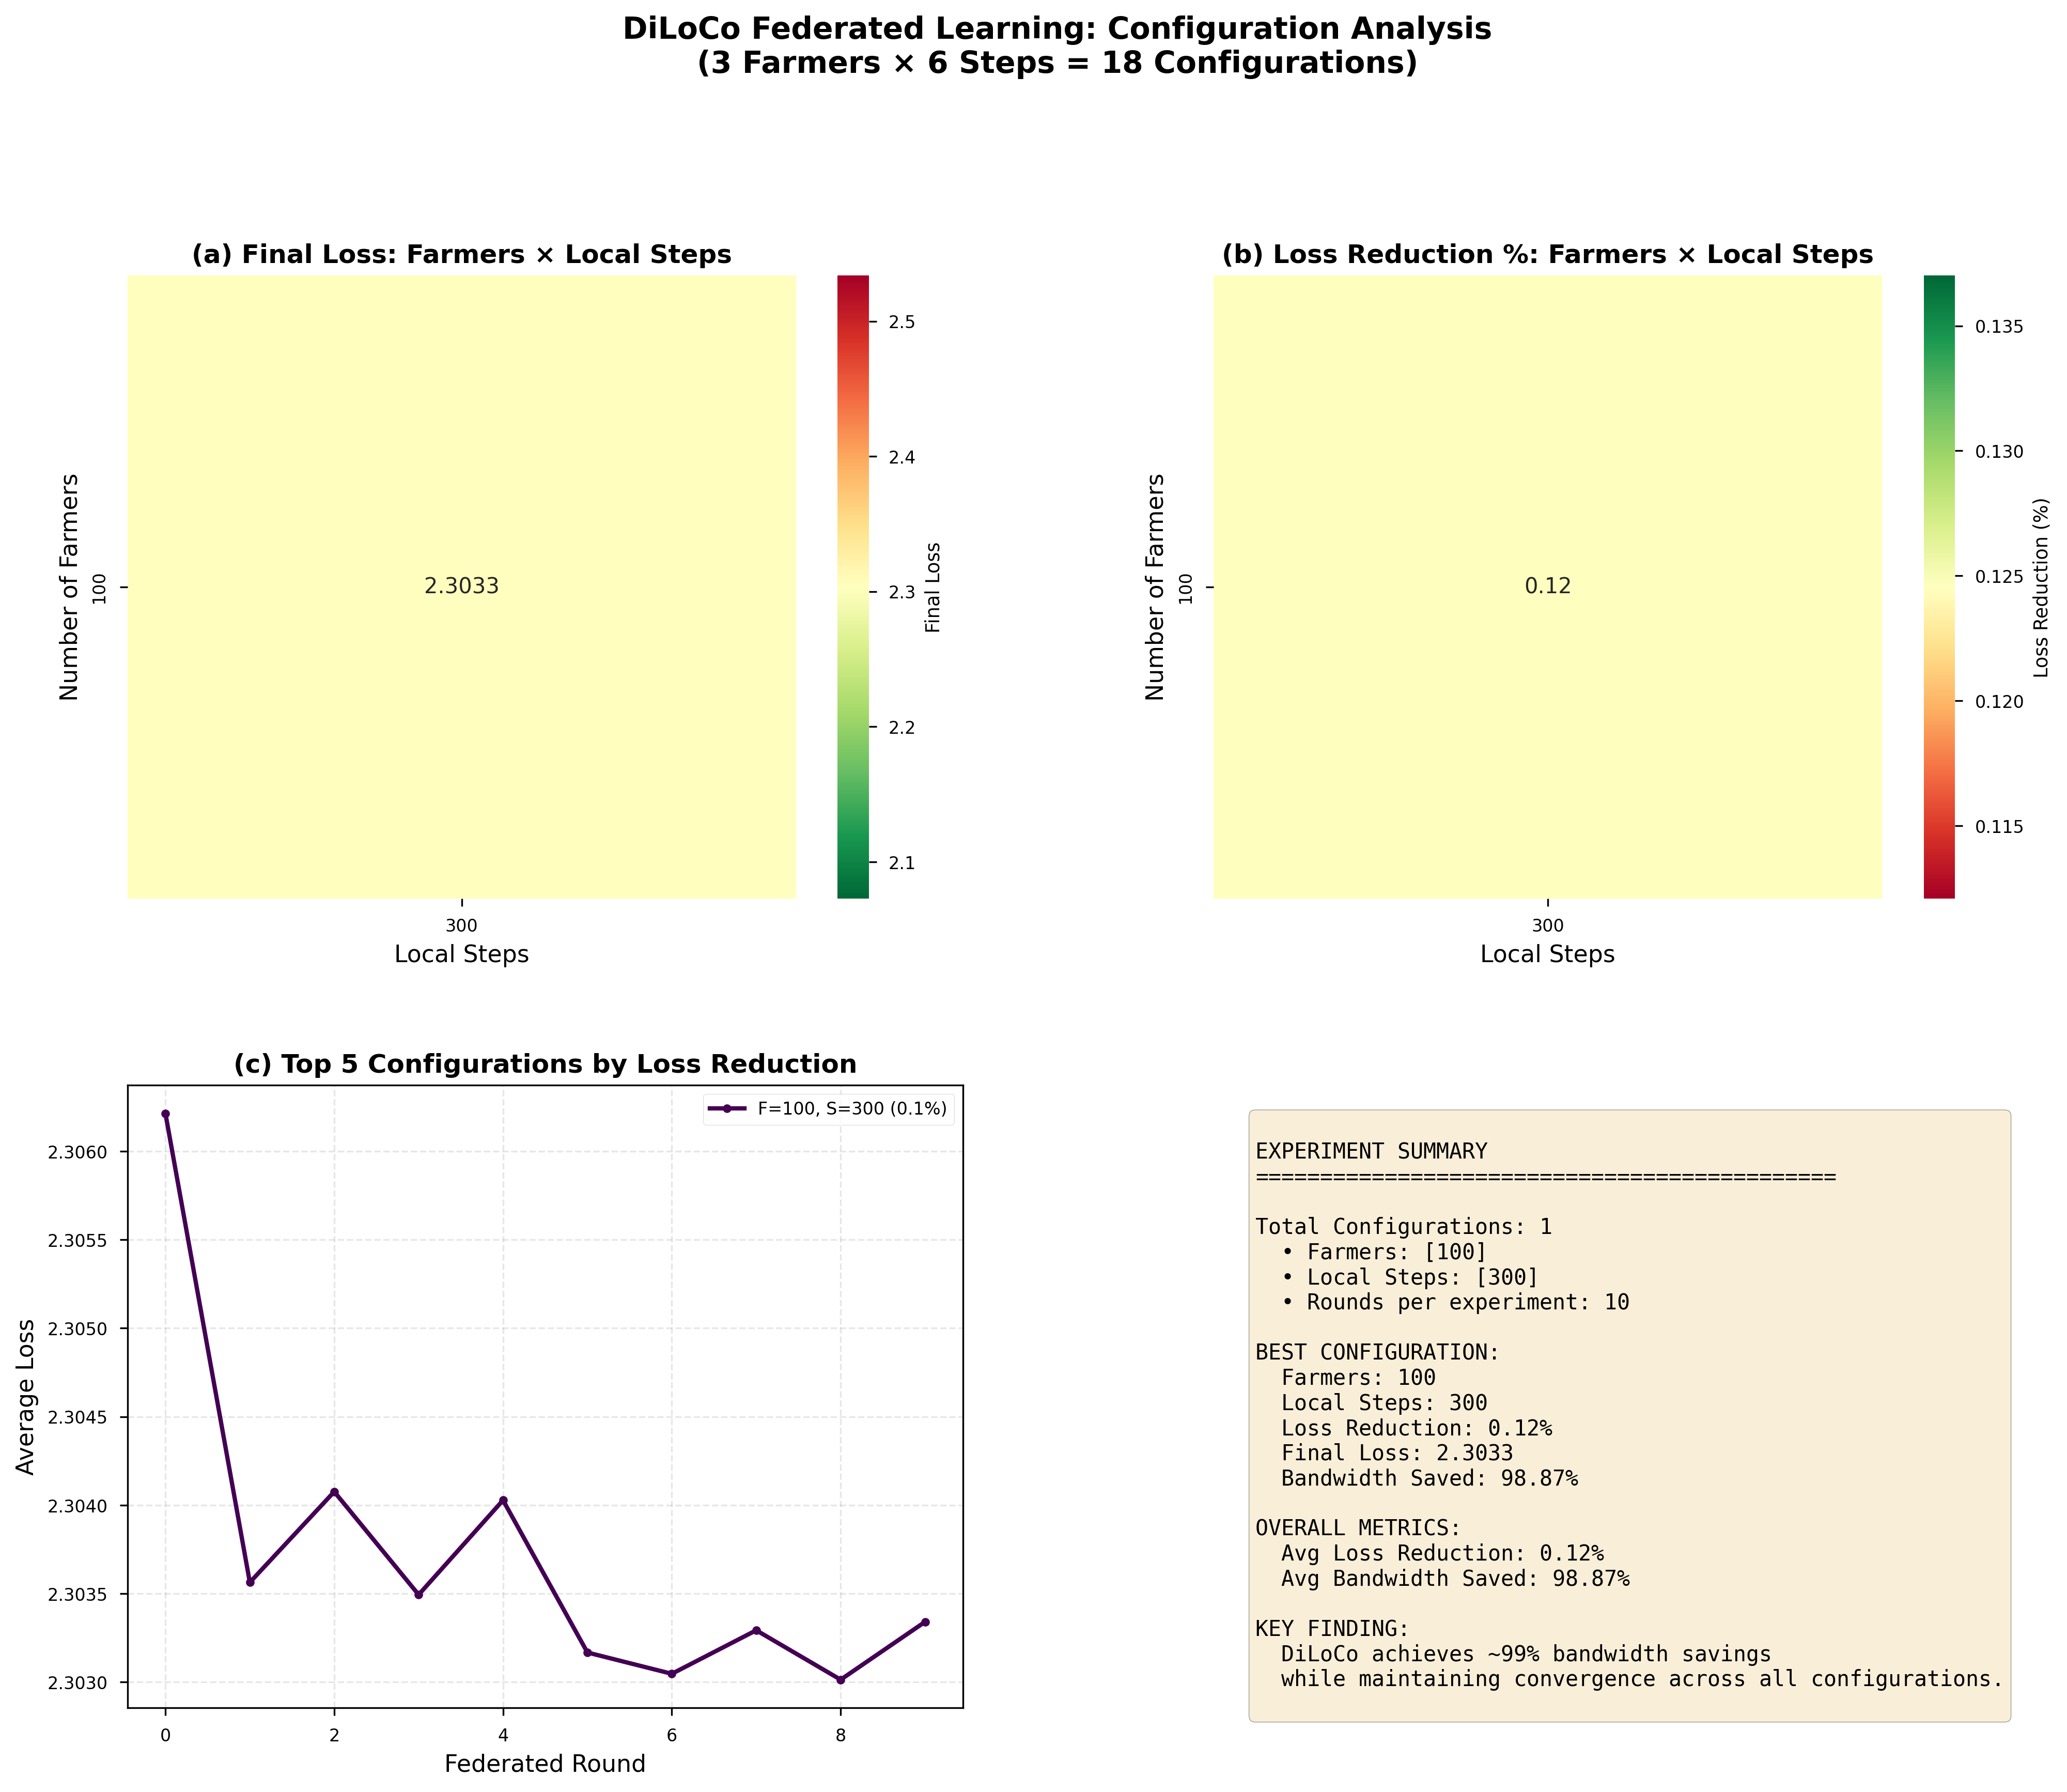

✅ Comprehensive paper figure saved!


In [8]:
# Create comprehensive figure for paper
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Subplot 1: Heatmap - Final Loss by Farmers x Steps
ax1 = fig.add_subplot(gs[0, 0])
pivot_loss = df_experiments.pivot_table(values='final_loss', index='num_farmers', columns='local_steps', aggfunc='mean')
sns.heatmap(pivot_loss, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=ax1, cbar_kws={'label': 'Final Loss'})
ax1.set_title('(a) Final Loss: Farmers × Local Steps', fontsize=12, fontweight='bold')
ax1.set_xlabel('Local Steps', fontsize=11)
ax1.set_ylabel('Number of Farmers', fontsize=11)

# Subplot 2: Heatmap - Loss Reduction by Farmers x Steps
ax2 = fig.add_subplot(gs[0, 1])
pivot_reduction = df_experiments.pivot_table(values='loss_reduction_pct', index='num_farmers', columns='local_steps', aggfunc='mean')
sns.heatmap(pivot_reduction, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2, cbar_kws={'label': 'Loss Reduction (%)'})
ax2.set_title('(b) Loss Reduction %: Farmers × Local Steps', fontsize=12, fontweight='bold')
ax2.set_xlabel('Local Steps', fontsize=11)
ax2.set_ylabel('Number of Farmers', fontsize=11)

# Subplot 3: Best configurations convergence curves
ax3 = fig.add_subplot(gs[1, 0])
top_configs = df_experiments.nlargest(5, 'loss_reduction_pct')
colors = plt.cm.viridis(np.linspace(0, 1, len(top_configs)))
for idx, (_, row) in enumerate(top_configs.iterrows()):
    label = f"F={row['num_farmers']}, S={row['local_steps']} ({row['loss_reduction_pct']:.1f}%)"
    ax3.plot(row['rounds_data'], row['loss_data'], 
            marker='o', linewidth=2, markersize=4, color=colors[idx], label=label)
ax3.set_xlabel('Federated Round', fontsize=11)
ax3.set_ylabel('Average Loss', fontsize=11)
ax3.set_title('(c) Top 5 Configurations by Loss Reduction', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.legend(fontsize=8, loc='upper right')

# Subplot 4: Summary statistics
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

best_config = df_experiments.loc[df_experiments['loss_reduction_pct'].idxmax()]

summary_text = f"""
EXPERIMENT SUMMARY
{'='*45}

Total Configurations: {len(df_experiments)}
  • Farmers: {sorted(df_experiments['num_farmers'].unique())}
  • Local Steps: {sorted(df_experiments['local_steps'].unique())}
  • Rounds per experiment: {df_experiments['num_rounds'].iloc[0]}

BEST CONFIGURATION:
  Farmers: {best_config['num_farmers']}
  Local Steps: {best_config['local_steps']}
  Loss Reduction: {best_config['loss_reduction_pct']:.2f}%
  Final Loss: {best_config['final_loss']:.4f}
  Bandwidth Saved: {best_config['avg_bandwidth_saved']:.2f}%

OVERALL METRICS:
  Avg Loss Reduction: {df_experiments['loss_reduction_pct'].mean():.2f}%
  Avg Bandwidth Saved: {df_experiments['avg_bandwidth_saved'].mean():.2f}%
  
KEY FINDING:
  DiLoCo achieves ~{df_experiments['avg_bandwidth_saved'].mean():.0f}% bandwidth savings
  while maintaining convergence across all configurations.
"""
ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('DiLoCo Federated Learning: Configuration Analysis\n(3 Farmers × 6 Steps = 18 Configurations)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.savefig(results_dir / 'plots' / 'paper_figure_comprehensive.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Comprehensive paper figure saved!")

## 6. Export Results for LaTeX Tables

In [9]:
# Create comprehensive comparison table for paper
df_table = df_experiments[['num_farmers', 'local_steps', 'num_rounds',
                           'initial_loss', 'final_loss', 'loss_reduction_pct', 
                           'avg_bandwidth_saved']].copy()

df_table.columns = ['Farmers', 'Steps', 'Rounds', 'Initial Loss', 'Final Loss', 'Loss Red. (%)', 'BW Saved (%)']
df_table = df_table.round(4)

print("📊 Complete Experiment Results:")
print("="*80)
display(df_table)

# Summary by number of farmers
print("\n📊 Summary by Number of Farmers:")
summary_farmers = df_experiments.groupby('num_farmers').agg({
    'final_loss': ['mean', 'std', 'min'],
    'loss_reduction_pct': ['mean', 'max'],
    'avg_bandwidth_saved': 'mean'
}).round(4)
summary_farmers.columns = ['Loss (mean)', 'Loss (std)', 'Loss (min)', 'Red. (mean)', 'Red. (max)', 'BW Saved (%)']
display(summary_farmers)

# Summary by local steps
print("\n📊 Summary by Local Steps:")
summary_steps = df_experiments.groupby('local_steps').agg({
    'final_loss': ['mean', 'std', 'min'],
    'loss_reduction_pct': ['mean', 'max'],
    'avg_bandwidth_saved': 'mean'
}).round(4)
summary_steps.columns = ['Loss (mean)', 'Loss (std)', 'Loss (min)', 'Red. (mean)', 'Red. (max)', 'BW Saved (%)']
display(summary_steps)

# Export to LaTeX with proper formatting and comments
tables_dir = results_dir / 'tables'
tables_dir.mkdir(parents=True, exist_ok=True)

def generate_latex_file(title, table_content, filename):
    """Generate a complete LaTeX file with comments for easy use."""
    header = f'''% ============================================================================
% DiLoCo Experiment Results - {title}
% ============================================================================
%
% HOW TO USE THIS FILE:
% ---------------------
% Option 1: Standalone Preview (Overleaf/pdflatex)
%   - Upload this entire file to Overleaf and compile
%   - Or run: pdflatex {filename}
%
% Option 2: Include in Your Paper
%   - Copy ONLY the content between "COPY START" and "COPY END" markers
%   - Make sure your main document has: \\usepackage{{booktabs}}
%
% ============================================================================

% --- DO NOT COPY (for standalone preview only) ---
\\documentclass{{article}}
\\usepackage{{booktabs}}
\\usepackage[margin=1in]{{geometry}}

\\begin{{document}}
% --- END DO NOT COPY ---

% ============================================================================
% COPY START - Paste this into your paper
% ============================================================================

{table_content}

% ============================================================================
% COPY END
% ============================================================================

% --- DO NOT COPY (for standalone preview only) ---
\\end{{document}}
% --- END DO NOT COPY ---
'''
    return header

# Get best configuration for highlighting
best_idx = df_table['Loss Red. (%)'].idxmax()
best_config = df_experiments.loc[df_experiments['loss_reduction_pct'].idxmax()]
num_configs = len(df_experiments)
num_steps = len(df_experiments['local_steps'].unique())

# 1. Generate full results table
full_rows = []
for i, row in df_table.iterrows():
    loss_red = f"\\textbf{{{row['Loss Red. (%)']:.2f}}}" if i == best_idx else f"{row['Loss Red. (%)']:.2f}"
    full_rows.append(f"{int(row['Farmers'])} & {int(row['Steps'])} & {int(row['Rounds'])} & {row['Initial Loss']:.4f} & {row['Final Loss']:.4f} & {loss_red} & {row['BW Saved (%)']:.2f} \\\\")

# Add midrule between farmer groups
rows_per_group = num_steps
full_table = f'''\\begin{{table}}[h]
\\centering
\\caption{{DiLoCo Experiment Results ({num_configs} Configurations)}}
\\label{{tab:full_results}}
\\begin{{tabular}}{{rrrrrrl}}
\\toprule
Farmers & Steps & Rounds & Initial Loss & Final Loss & Loss Red. (\\%) & BW Saved (\\%) \\\\
\\midrule
''' + '\n'.join(full_rows[:rows_per_group]) + '\n\\midrule\n' + '\n'.join(full_rows[rows_per_group:2*rows_per_group]) + '\n\\midrule\n' + '\n'.join(full_rows[2*rows_per_group:]) + '''
\\bottomrule
\\end{tabular}
\\end{table}'''

with open(tables_dir / 'full_results.tex', 'w') as f:
    f.write(generate_latex_file('Full Results Table', full_table, 'full_results.tex'))

# 2. Generate summary by farmers table
farmers_table = '''\\begin{table}[h]
\\centering
\\caption{Results Summary by Number of Farmers}
\\label{tab:summary_farmers}
\\begin{tabular}{rrrrrrl}
\\toprule
Farmers & Loss (mean) & Loss (std) & Loss (min) & Red. (mean) & Red. (max) & BW Saved (\\%) \\\\
\\midrule
'''
for farmers, row in summary_farmers.iterrows():
    red_max = f"\\textbf{{{row['Red. (max)']:.2f}}}" if row['Red. (max)'] == summary_farmers['Red. (max)'].max() else f"{row['Red. (max)']:.2f}"
    farmers_table += f"{farmers} & {row['Loss (mean)']:.4f} & {row['Loss (std)']:.4f} & {row['Loss (min)']:.4f} & {row['Red. (mean)']:.2f} & {red_max} & {row['BW Saved (%)']:.2f} \\\\\n"
farmers_table += '''\\bottomrule
\\end{tabular}
\\end{table}'''

with open(tables_dir / 'summary_by_farmers.tex', 'w') as f:
    f.write(generate_latex_file('Summary by Number of Farmers', farmers_table, 'summary_by_farmers.tex'))

# 3. Generate summary by steps table
steps_table = '''\\begin{table}[h]
\\centering
\\caption{Results Summary by Local Steps}
\\label{tab:summary_steps}
\\begin{tabular}{rrrrrrl}
\\toprule
Steps & Loss (mean) & Loss (std) & Loss (min) & Red. (mean) & Red. (max) & BW Saved (\\%) \\\\
\\midrule
'''
for steps, row in summary_steps.iterrows():
    red_max = f"\\textbf{{{row['Red. (max)']:.2f}}}" if row['Red. (max)'] == summary_steps['Red. (max)'].max() else f"{row['Red. (max)']:.2f}"
    steps_table += f"{steps} & {row['Loss (mean)']:.4f} & {row['Loss (std)']:.4f} & {row['Loss (min)']:.4f} & {row['Red. (mean)']:.2f} & {red_max} & {row['BW Saved (%)']:.2f} \\\\\n"
steps_table += '''\\bottomrule
\\end{tabular}
\\end{table}'''

with open(tables_dir / 'summary_by_steps.tex', 'w') as f:
    f.write(generate_latex_file('Summary by Local Steps', steps_table, 'summary_by_steps.tex'))

# 4. Generate overall summary table
summary_table = f'''\\begin{{table}}[h]
\\centering
\\caption{{DiLoCo Simulation Results - Overall Summary}}
\\label{{tab:results_summary}}
\\begin{{tabular}}{{ll}}
\\toprule
Metric & Value \\\\
\\midrule
Total Configurations Tested & {num_configs} \\\\
Number of Farmers & {', '.join(map(str, sorted(df_experiments['num_farmers'].unique())))} \\\\
Local Training Steps & {', '.join(map(str, sorted(df_experiments['local_steps'].unique())))} \\\\
Federated Rounds & {df_experiments['num_rounds'].iloc[0]} \\\\
\\midrule
Average Bandwidth Savings (\\%) & {df_experiments['avg_bandwidth_saved'].mean():.2f} \\\\
Average Loss Reduction (\\%) & {df_experiments['loss_reduction_pct'].mean():.2f} \\\\
Best Loss Reduction (\\%) & \\textbf{{{best_config['loss_reduction_pct']:.2f}}} ({int(best_config['num_farmers'])} farmers, {int(best_config['local_steps'])} steps) \\\\
\\midrule
Best Final Loss & {df_experiments['final_loss'].min():.4f} \\\\
Worst Final Loss & {df_experiments['final_loss'].max():.4f} \\\\
\\bottomrule
\\end{{tabular}}
\\end{{table}}'''

with open(tables_dir / 'results_summary.tex', 'w') as f:
    f.write(generate_latex_file('Overall Summary', summary_table, 'results_summary.tex'))

print(f"\n✅ LaTeX tables saved to: {tables_dir}")
print("   - full_results.tex")
print("   - summary_by_farmers.tex")
print("   - summary_by_steps.tex")
print("   - results_summary.tex")
print("\n📝 Each file contains comments explaining how to use it in your paper.")

📊 Complete Experiment Results:


,Farmers,Steps,Rounds,Initial Loss,Final Loss,Loss Red. (%),BW Saved (%)
0,100,300,10,2.3062,2.3033,0.1246,98.8684



📊 Summary by Number of Farmers:


,Loss (mean),Loss (std),Loss (min),Red. (mean),Red. (max),BW Saved (%)
num_farmers,,,,,,
100,2.3033,NaN,2.3033,0.1246,0.1246,98.8684



📊 Summary by Local Steps:


,Loss (mean),Loss (std),Loss (min),Red. (mean),Red. (max),BW Saved (%)
local_steps,,,,,,
300,2.3033,NaN,2.3033,0.1246,0.1246,98.8684



✅ LaTeX tables saved to: ../experiments/results/tables
   - full_results.tex
   - summary_by_farmers.tex
   - summary_by_steps.tex
   - results_summary.tex

📝 Each file contains comments explaining how to use it in your paper.


## Next Steps

1. ✅ Analyze simulation results
2. ✅ Generate paper-ready figures
3. ⬜ Integrate real WeedsGalore dataset
4. ⬜ Add YOLOv11 + proper LoRA implementation
5. ⬜ Run full experiments with different configurations
6. ⬜ Write paper sections using these results